In [1]:
library('DESeq2')
library('RColorBrewer')
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

Load and format expression file

In [2]:
all_exp <- read.csv('../../../Rat-Pilot/data/tag_directories/merged-all.rlog.txt',sep='\t',
                    col.names=c('PeakID','Chr','Start','End','Strand','Peak.Score','Focus.Ratio.Region.Size','Annotation',
                                'Detailed.Annotation','Distance.to.TSS','Nearest.PromoterID','Entrez.ID','Nearest.Unigene',
                                'Nearest.Refseq','Nearest.Ensembl','Gene.Name','Gene.Alias','Gene.Description','Gene.Type','IL','PL',
                                'ST','AC','AS','VTA'))
all_exp$Annotation <- toupper(all_exp$Annotation)
head(all_exp)

PeakID,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,⋯,Gene.Name,Gene.Alias,Gene.Description,Gene.Type,IL,PL,ST,AC,AS,VTA
<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<fct>,<chr>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Merged-chr4-77447614-7,chr4,77446325,77448719,+,488.4143,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac6-AS/regions.txt,INTERGENIC,Intergenic,42013,⋯,Pdia4,ERp-72|Erp70|Erp72,"protein disulfide isomerase family A, member 4",protein-coding,11.486580,11.592882,11.369450,11.455429,11.541023,11.206650
Merged-chr12-13804183-10,chr12,13798571,13812426,+,287.9100,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac5-AC/regions.txt|H3K27ac6-AS/regions.txt|H3K27ac7-VTA/regions.txt,INTERGENIC,Intergenic,-2321,⋯,Tnrc18,Zfp469,trinucleotide repeat containing 18,protein-coding,10.518769,10.435693,10.974241,10.252431,10.399940,10.374023
Merged-chr12-38873382-8,chr12,38869851,38879308,+,211.8375,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac5-AC/regions.txt|H3K27ac6-AS/regions.txt|H3K27ac7-VTA/regions.txt,INTERGENIC,Intergenic,41655,⋯,Tmem120b,-,transmembrane protein 120B,protein-coding,9.811939,9.805325,10.217660,9.469130,9.758923,9.933961
Merged-chr4-58505254-7,chr4,58501851,58509994,+,204.8914,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac5-AC/regions.txt|H3K27ac6-AS/regions.txt|H3K27ac7-VTA/regions.txt,INTERGENIC,UCON29|DNA|Kolobok,-161532,⋯,Mir29b1,Mir29b-1|rno-mir-29b-1,microRNA 29b-1,ncRNA,9.317609,9.653931,10.054095,9.315937,9.290063,9.478464
Merged-chr6-110903817-6,chr6,110901168,110906468,+,203.9167,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac5-AC/regions.txt|H3K27ac6-AS/regions.txt|H3K27ac7-VTA/regions.txt,"EXON (NM_001012470, EXON 1 OF 1)","exon (NM_001012470, exon 1 of 1)",470,⋯,Irf2bpl,Eap1|Pqcp|RGD1310994,interferon regulatory factor 2 binding protein-like,protein-coding,9.280835,9.398107,9.625998,8.983863,9.111870,9.107477
Merged-chr10-37314029-6,chr10,37311085,37317544,+,194.2333,H3K27ac1-IL/regions.txt|H3K27ac2-PL/regions.txt|H3K27ac4-ST/regions.txt|H3K27ac5-AC/regions.txt|H3K27ac6-AS/regions.txt|H3K27ac7-VTA/regions.txt,INTERGENIC,CpG,-2689,⋯,Jade2,Phf15,jade family PHD finger 2,protein-coding,9.100498,9.177305,9.639574,8.882499,9.036331,9.487353


In [3]:
distal_exp <- read.csv('../../../Rat-Pilot/data/tag_directories/merged-distal.rlog.txt',sep='\t',
                       col.names=c('PeakID','Chr','Start','End','Strand','Peak.Score','Focus.Ratio.Region.Size','Annotation',
                                   'Detailed.Annotation','Distance.to.TSS','Nearest.PromoterID','Entrez.ID','Nearest.Unigene',
                                   'Nearest.Refseq','Nearest.Ensembl','Gene.Name','Gene.Alias','Gene.Description','Gene.Type','IL','PL',
                                   'ST','AC','AS','VTA'))
head(distal_exp)

PeakID,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,⋯,Gene.Name,Gene.Alias,Gene.Description,Gene.Type,IL,PL,ST,AC,AS,VTA
<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Merged-chr4-77447614-7,chr4,77446325,77448719,+,488.4143,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac6-AS/regions-distal.txt,Intergenic,Intergenic,42013,⋯,Pdia4,ERp-72|Erp70|Erp72,"protein disulfide isomerase family A, member 4",protein-coding,11.484885,11.602431,11.37885,11.437943,11.530435,11.213555
Merged-chr10-86663032-7,chr10,86653749,86673177,+,290.8714,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac5-AC/regions-distal.txt|H3K27ac6-AS/regions-distal.txt|H3K27ac7-VTA/regions-distal.txt,"intron (NM_001017960, intron 1 of 8)","intron (NM_001017960, intron 1 of 8)",-5770,⋯,Thra,ERBA1|Thra1|c-erbA-1,thyroid hormone receptor alpha,protein-coding,10.498940,10.590764,11.00120,10.443036,10.422055,10.696226
Merged-chr2-188000421-8,chr2,187991336,188006123,+,258.4500,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac5-AC/regions-distal.txt|H3K27ac6-AS/regions-distal.txt|H3K27ac7-VTA/regions-distal.txt,"intron (NM_001012079, intron 1 of 21)","intron (NM_001012079, intron 1 of 21)",4931,⋯,Arhgef2,-,Rho/Rac guanine nucleotide exchange factor 2,protein-coding,10.233502,10.312821,10.61850,10.163679,10.140780,10.626215
Merged-chr12-38873382-8,chr12,38869851,38879308,+,211.8375,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac5-AC/regions-distal.txt|H3K27ac6-AS/regions-distal.txt|H3K27ac7-VTA/regions-distal.txt,Intergenic,Intergenic,41655,⋯,Tmem120b,-,transmembrane protein 120B,protein-coding,9.810572,9.815572,10.22544,9.452997,9.749286,9.939129
Merged-chr4-58505254-7,chr4,58501851,58509994,+,204.8914,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac5-AC/regions-distal.txt|H3K27ac6-AS/regions-distal.txt|H3K27ac7-VTA/regions-distal.txt,Intergenic,UCON29|DNA|Kolobok,-161532,⋯,Mir29b1,Mir29b-1|rno-mir-29b-1,microRNA 29b-1,ncRNA,9.316471,9.663856,10.06196,9.299286,9.280606,9.483892
Merged-chr7-139275764-5,chr7,139271293,139279460,+,194.3800,H3K27ac1-IL/regions-distal.txt|H3K27ac2-PL/regions-distal.txt|H3K27ac4-ST/regions-distal.txt|H3K27ac5-AC/regions-distal.txt|H3K27ac7-VTA/regions-distal.txt,"intron (NM_001127456, intron 1 of 2)",tRNA-Ala-GCA|tRNA|tRNA,3678,⋯,Slc48a1,HRG-1|Hrg1,solute carrier family 48 member 1,protein-coding,9.148361,9.307769,9.55112,9.078237,9.034622,9.688760


Subset annotations by region

In [4]:
promoter <- subset(all_exp,grepl('PROMOTER',all_exp$Annotation))

Format dataframe for heatmap

In [5]:
#Set PeakID as the rownames
rownames(promoter) <- promoter$PeakID
promoter$PeakID <- NULL

rownames(distal_exp) <- distal_exp$PeakID
distal_exp$PeakID <- NULL

In [6]:
#Limit dataframe to experiments.
promoter <- promoter[,c(19:24)]

distal_exp <- distal_exp[,c(19:24)]

In [7]:
#Get sample distances.
promoterDists <- dist(t(promoter))
promoterDistsMatrix <- as.matrix(promoterDists)
colnames(promoterDistsMatrix) <- NULL

distalDists <- dist(t(distal_exp))
distalDistsMatrix <- as.matrix(distalDists)
colnames(distalDistsMatrix) <- NULL

Plot heatmap

In [8]:
colors <- colorRampPalette(rev(brewer.pal(6,"Blues")))(255)

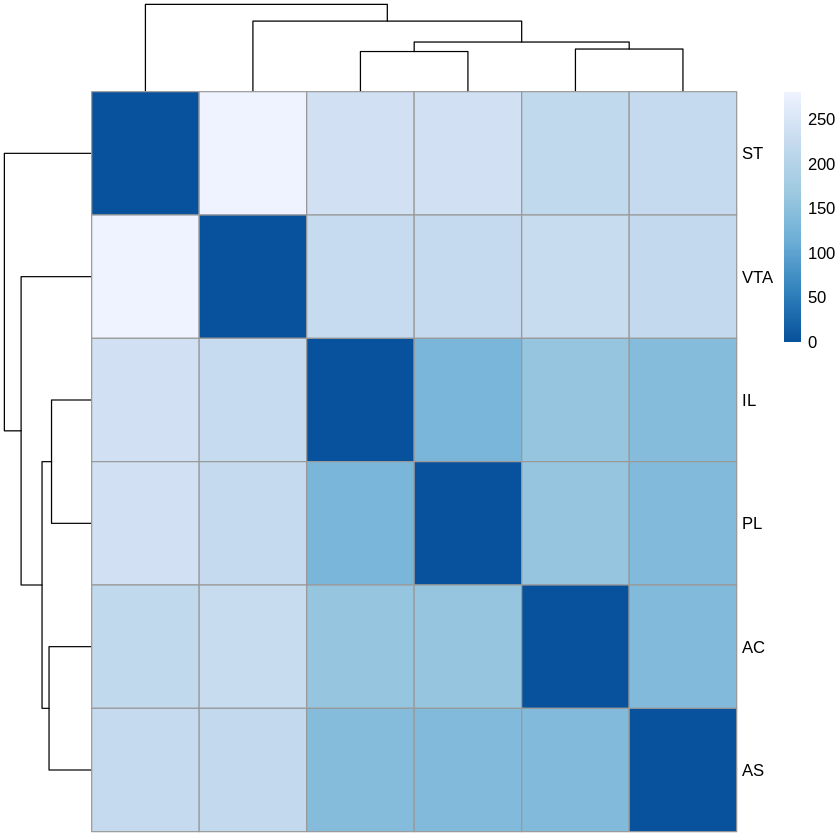

In [9]:
pheatmap(distalDistsMatrix,
         clustering_distance_rows=distalDists,
         clustering_distance_cols=distalDists,
         col=colors)

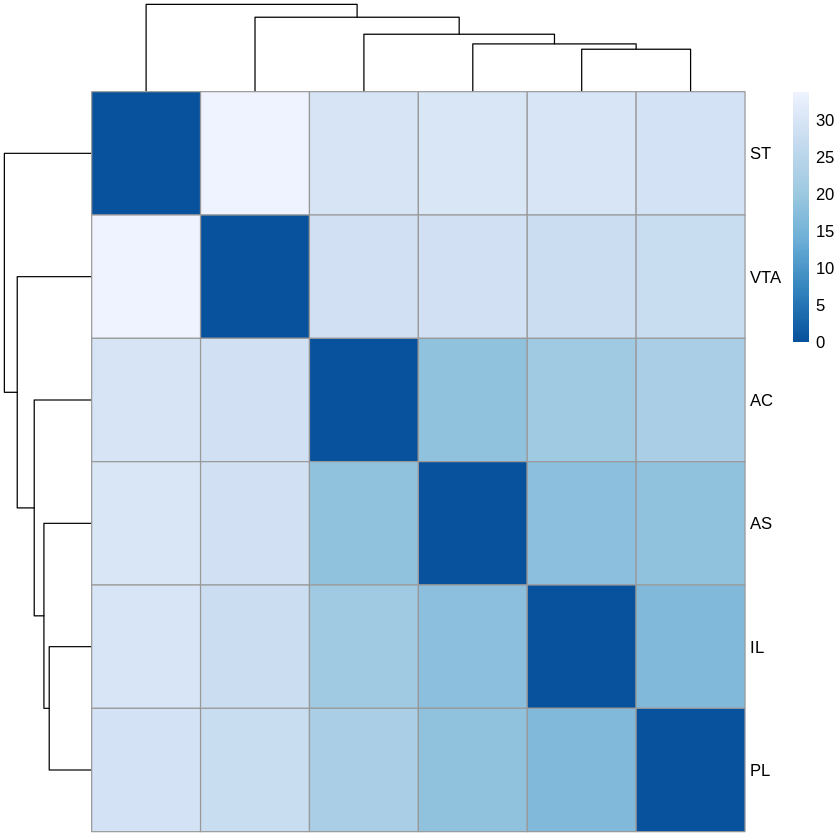

In [10]:
pheatmap(promoterDistsMatrix,
         clustering_distance_rows=promoterDists,
         clustering_distance_cols=promoterDists,
         col=colors)